In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
"""
Blackbox Attack

The blackbox attack works as follows:
Since we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".
This is done using a small sample of training data, labeled by the target model (aka the oracle) instead of using the true labels. 
This way, the substitute learns to mimic the target model.
In addition, we augment this training data using "Jacobian-based data augmentation" (TODO)
Finally, we use one of the regular attacks on the substitute model. Supposedly, an attack that works well against the substitute
will also work well against the target. 
"""

In [2]:
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.autograd.functional import jacobian
from torch.autograd import grad
from sklearn.model_selection import train_test_split

import team36
from team36.mnist.data_loading import MNIST_Loader
from team36.mnist.vgg import VGG
from team36.mnist.cnn import CNN
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.training import train, validate, accuracy, predict, predict_from_loader, do_training, load_or_train, train_val_split, train_batch

DIR = '.'
DATA_DIR = f'{DIR}/data'

In [ ]:
"""
Step 1
Train the target model (aka the Oracle) or load from a checkpoint
"""

In [3]:
"""
Set up the datasets
It is interesting to compare using the same dataset for the substitute and oracle vs. using different datasets
"""
ORACLE_DATASET = 'MNIST' # 'MNIST' or 'CIFAR10'
SUB_DATASET = 'MNIST' 
DATASET_NAMES = [ORACLE_DATASET, SUB_DATASET]
MODEL_NAMES = ['oracle', 'sub']
ORACLE = 0
SUB = 1
datasets = [] # two-element list to store the oracle dataset and the substitute dataset
dataset_image_sizes = []
dataset_channels = []
test_datasets = []

# class Grayscale_to_RGB(object):
#     def __call__(self, sample):
#         print(sample)
#         return sample

# def grayscale_to_rgb(sample):
#     print(sample)
#     return sample
# #     return sample.repeat(1, 3, 1, 1)

for idx, dataset_name in enumerate(DATASET_NAMES):
    transform_seq = [transforms.ToTensor()]
    if dataset_name == 'MNIST':
        image_size = 28
        in_channels = 1
        if idx == SUB and ORACLE_DATASET != 'MNIST': # if substitute uses mnist, but oracle uses other dataset add padding to match image size
            padding = (dataset_image_sizes[ORACLE] - image_size) // 2
            transform_seq.append(transforms.Pad(padding, fill=0))
            image_size += padding * 2
#             transform_seq.append(transforms.Lambda(lambda x: x))
            transform_seq.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1)))
            in_channels = 3 # also need to copy to 3 channels to match rgb cifar
            # NOTE: above assumes oracle_dataset has larger images and that there is an even number difference in the image sizes
        dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                              transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
#         if idx == SUB and ORACLE_DATASET != 'MNIST':
#             # also need to copy to image to 3 channels to match rgb cifar
# #             transform_seq.append(grayscale_to_rgb) # copy single channel to 3 channels (from https://discuss.pytorch.org/t/grayscale-to-rgb-transform/18315)
#             dataset.data = dataset.data.unsqueeze(1).repeat(1, 3, 1, 1)            
#             in_channels = 3
    elif dataset_name == 'CIFAR10':
        image_size = 32
        in_channels = 3
        dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True,
                                                transform=transforms.Compose(transform_seq))
        test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, 
                                              transform=transforms.Compose(transform_seq))
    datasets.append(dataset)
    dataset_image_sizes.append(image_size)
    dataset_channels.append(in_channels)
    test_datasets.append(test_dataset)

datasets

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


[Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [4]:
%%time
image_size = dataset_image_sizes[ORACLE]
in_channels = dataset_channels[ORACLE]
oracle = VGG(image_size=image_size, in_channels=in_channels) # set the target model here
oracle_checkpoint = f'{DATASET_NAMES[ORACLE]}-vgg.pth' # e.g. 'MNIST-vgg.pth'
# oracle_checkpoint = 'mnist-vgg.pth'
oracle_checkpoint = oracle_checkpoint.lower()

learning_rate = 5e-4
momentum = 5e-1
# momentum = .9
weight_decay = 1e-1
batch_size = 32
epochs = 10

load_or_train(oracle, oracle_checkpoint, dataset=datasets[ORACLE], epochs=epochs, learning_rate=learning_rate, 
              weight_decay=weight_decay, momentum=momentum, batch_size=batch_size,
             optim=torch.optim.SGD)
# hyperparam tuning notes: 
# small learning rate is good for VGG on CIFAR (0.001 better than 0.01 and much better than 0.1)

# if os.path.exists(oracle_checkpoint_path): # if trained checkpoint exists, load it
#     state_dict = torch.load(f"{DIR}/checkpoints/{checkpoint}", map_location=torch.device('cpu'))
#     model.load_state_dict(state_dict)
# else: # else, train the model
# training_indices, validation_indices, _, _ = train_test_split(
#     range(len(target_data)),
#     target_data.targets,
#     stratify=target_data.targets,
#     test_size=0.1,
# )
# oracle_train_split = torch.utils.data.Subset(target_data, training_indices)
# oracle_val_split = torch.utils.data.Subset(target_data, validation_indices)
# print(f"{len(oracle_train_split)} in training set")
# print(f"{len(oracle_val_split)} in validation set")

# do_training(oracle, training_split=oracle_train_split, validation_split=oracle_val_split, epochs=EPOCHS)

Wall time: 33.9 ms


In [ ]:
"""
Step 2
Train the substitute model on a small portion of the training data, using the oracle's predictions as the labels

oracle pred full mnist
replace targets
train val split (small train)
"""

In [56]:
sub = CNN(image_size = dataset_image_sizes[SUB], in_channels = dataset_channels[SUB])
sub_checkpoint = f'{DATASET_NAMES[SUB]}-substitute.pth' # e.g. 'MNIST-substitute.pth'

In [7]:
loader = torch.utils.data.DataLoader(datasets[SUB], batch_size=100, shuffle=False, num_workers=0)
# NOTE: due to a bug with lambda transforms on Windows, num_workers needs to be 0 or there will be an error
# https://github.com/belskikh/kekas/issues/26

In [8]:
datasets[SUB]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
# datasets[SUB].data.shape

In [ ]:
# for idx, (data, target) in enumerate(loader):
#         if torch.cuda.is_available():
#             data = data.cuda()
#             target = target.cuda()
#         print(data.shape)
# #         print(data.repeat(1, 3, 1, 1).shape)
#         print(target)
#         if idx > 1: break

In [34]:
%%time
oracle_preds = predict_from_loader(oracle, loader)

Wall time: 1min 27s


In [43]:
oracle_preds = oracle_preds.argmax(axis=1)

In [45]:
len(oracle_preds[oracle_preds != datasets[SUB].targets]) # check oracle preds mostly matches true labels (if oracle was trained on same dataset)

0

In [44]:
datasets[SUB].targets = oracle_preds # replace true labels with oracle's predictions

In [ ]:
train[1][0].shape

In [ ]:
%%time
# run either this cell (simple blackbox training) OR the next one (blackbox w/ jacobian-based data augmentation)
epochs = 30
train_size = 10000
train = Subset(datasets[SUB], range(train_size))
val = Subset(datasets[SUB], range(train_size, train_size*2)) # val split same size as train split
load_or_train(sub, sub_checkpoint, train_split=train, val_split=val, epochs=epochs)

In [76]:
%%time
# train with Jacobian-based data augmentation
# here, training starts with a small sample from the training data
# we train on this over some number of "sub_epochs"
# then, we augment the data by adding the sign of the Jacobian times a constant (or just the Jacobian times a constant?)
# repeat over some number of epochs
epochs = 6
sub_epochs = 15
# train_size = 1000
batch_size = 150
step_size = 0.1
learning_rate = 0.05
momentum = 0.9
# train = Subset(datasets[SUB], range(train_size))
# val = Subset(datasets[SUB], range(train_size, train_size*2)) # val split same size as train split
loader = torch.utils.data.DataLoader(test_datasets[SUB], batch_size=batch_size, shuffle=False, num_workers=0)
batch_iter = iter(loader)
X = batch_iter.next() # we just need one batch. result is: [[data], [targets]]
for epoch in range(epochs):
    sub = CNN(image_size = dataset_image_sizes[SUB], in_channels = dataset_channels[SUB]) # model is trained from scratch each time on the new augmented dataset
    print('epoch', epoch)
    print('len X', len(X[0]))
#     train = Subset(datasets[SUB], range(epoch*batch_size, epoch*batch_size+batch_size))
#     train = X
#     print('training')
    train_batch(X, sub, epochs=sub_epochs, learning_rate=learning_rate, momentum=momentum)
#     print('done training')
#     do_training(model, training_split=train, validation_split=train, epochs=sub_epochs) # train on batch 
    # generate the next batch using Jacobian data-augmentation
#     print('augmentation')
    X_size = len(X[0])
    for i in range(X_size):
        x = X[0][i] # X[0] gets data from batch, [i] gets the i'th data point
        x = x.unsqueeze(0) # need to pass a batch to the Jacobian, so we make a one-element batch 
#         print('getting jacobian')
        J = jacobian(sub, x)
        J = J.squeeze(0).squeeze(1) # switch from batch Jacobian back to single
#         print('getting label')
        label = oracle_preds[epoch*batch_size + i]
#         print('label', label)
        J = J[label] # only need jacobian for the corresponding label
#         print('got J for label')
#         X[0][i] += J # modify the input using the Jacobian
        J = torch.sign(J) # only want the sign of the Jacobian
        # don't just modify the examples X; modify and concat with the original examples to get a larger training set
#         print('modifying x')
        new_x = X[0][i] + step_size * J
        new_x = new_x.unsqueeze(0) # make into a batch so we can cat
#         print('catting new x')
        X[0] = torch.cat((X[0], new_x), 0)
#         X[0][i] = X[0][i] + step_size * J 
#     print('making new preds')
    new_preds = torch.argmax(oracle(X[0]), axis=1) # get predictions for augmented dataset
#     new_preds = torch.argmax(oracle(X[0][epoch*batch_size:(epoch+1)*batch_size]), axis=1) # get predictions for the new batch
#     new_preds = new_preds.unsqueeze(0)
    X[1] = new_preds

epoch 0
len X 150
Epoch 0 | Training accuracy: 0.14000000059604645%
Epoch 1 | Training accuracy: 0.2800000011920929%
Epoch 2 | Training accuracy: 0.4466666579246521%
Epoch 3 | Training accuracy: 0.6666666865348816%
Epoch 4 | Training accuracy: 0.800000011920929%
Epoch 5 | Training accuracy: 0.8600000143051147%
Epoch 6 | Training accuracy: 0.8600000143051147%
Epoch 7 | Training accuracy: 0.9133333563804626%
Epoch 8 | Training accuracy: 0.9200000166893005%
Epoch 9 | Training accuracy: 0.9200000166893005%
Epoch 10 | Training accuracy: 0.9399999976158142%
Epoch 11 | Training accuracy: 0.9399999976158142%
Epoch 12 | Training accuracy: 0.9399999976158142%
Epoch 13 | Training accuracy: 0.9733333587646484%
Epoch 14 | Training accuracy: 0.9666666388511658%
epoch 1
len X 300
Epoch 0 | Training accuracy: 0.09000000357627869%
Epoch 1 | Training accuracy: 0.25999999046325684%
Epoch 2 | Training accuracy: 0.4933333396911621%
Epoch 3 | Training accuracy: 0.7633333206176758%
Epoch 4 | Training accurac

In [13]:
# loader = torch.utils.data.DataLoader(datasets[SUB], batch_size=batch_size, shuffle=False, num_workers=0)
# batch_iter = iter(loader)
# X = batch_iter.next() 

In [25]:
# torch.argmax(oracle(X[0]), axis=1)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])

In [52]:
oracle(X[0][1:3])

tensor([[ 9.4169, -4.7919,  2.0163,  0.0857, -3.7622, -1.2417,  1.3576, -1.5906,
          0.9843,  0.5568],
        [-3.8718, -1.2136,  0.5668,  0.5602,  6.8551, -1.6826, -1.3260,  0.2603,
         -0.6687,  2.3064]], grad_fn=<AddmmBackward>)

In [ ]:
# batch_iter = iter(loader)
# X = batch_iter.next() 

In [ ]:
"""
Step 3
Generate attack data for the substitute model and test both models with it
"""

In [27]:
target = oracle
criterion = nn.CrossEntropyLoss()
models = [oracle]
# models = [oracle, sub]

In [28]:
test_datasets

[Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            )]

In [29]:
"""Regular Test"""
# test_set = torchvision.datasets.MNIST(root=DATA_DIR, train=False, download=True, 
#                                       transform=transforms.ToTensor())
test_set = test_datasets[ORACLE] # since the substitute tries to mimic the oracle, we may as well test on the oracle's test set
for model, name in zip(models, MODEL_NAMES):
    print(name)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Regular Test Accuracy is {test_accuracy}")
    print(f"{name} Regular Test Loss is {test_loss}")

oracle
oracle Regular Test Accuracy is 0.9839000105857849
oracle Regular Test Loss is 0.063465915620327


In [80]:
%%time
"""Attack Test"""
test_set = test_datasets[ORACLE] # since the substitute tries to mimic the oracle, we may as well test on the oracle's test set
attack_test_set = FastSignGradientAttackDataSet(test_set, sub, criterion, epsilon=0.25)

for model, name in zip(models, MODEL_NAMES):
    print(name)
    test_loader = torch.utils.data.DataLoader(attack_test_set, batch_size=100, shuffle=False, num_workers=0)

    test_accuracy, _, test_loss = validate(None, test_loader, model, criterion)

    print(f"{name} Attack Test Accuracy is {test_accuracy}")
    print(f"{name} Attack Test Loss is {test_loss}")

oracle
oracle Attack Test Accuracy is 0.7071999907493591
oracle Attack Test Loss is 0.8207333087921143
Wall time: 20.4 s


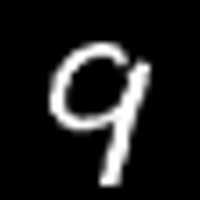

9
tensor([[2.2411e-05, 4.9409e-07, 3.8254e-05, 1.8362e-04, 2.9749e-04, 7.0736e-05,
         1.6132e-06, 3.4059e-03, 1.2733e-04, 9.9585e-01]],
       grad_fn=<SoftmaxBackward>)


C:\Users\bkest\Documents\OMSCS\Deep_Learning\project\omscs-dl-final-project\team36\training.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(out)


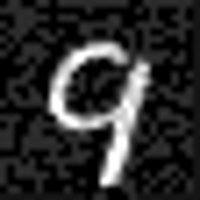

9
tensor([[1.2416e-04, 1.2717e-05, 3.2222e-04, 6.8261e-04, 2.4576e-03, 4.9085e-04,
         1.4254e-05, 2.3854e-02, 2.4717e-04, 9.7179e-01]],
       grad_fn=<SoftmaxBackward>)
True label tensor(9)


In [31]:
model = oracle
index = 16
# some clear images: 1=ship, 16=dog
disp_width, disp_height = 200, 200

input, _ = test_set[index]
img = transforms.functional.to_pil_image(input)
display(img.resize((disp_width, disp_height)))
print(predict(model, input, soft=False))
print(predict(model, input, soft=True))

input, _ = attack_test_set[index]
attack_img = transforms.functional.to_pil_image(input)
display(attack_img.resize((disp_width, disp_height)))
print(predict(model, input, soft=False))
print(predict(model, input, soft=True))

print('True label', test_set.targets[index])

# input, _ = attack_test_set[index]
# display(transforms.functional.to_pil_image(input))
# print(predict(defense_model, input))

# input, _ = attack_test_set[index]
# display(transforms.functional.to_pil_image(input))
# print(predict(fgsm_reg_defense_model, input))

In [ ]:
%%time
batch = iter(test_loader).next()[0]
J = jacobian(sub, batch)

In [ ]:
%%time
batch = iter(test_loader).next()[0]
J = jacobian(sub, batch[0].unsqueeze(0))

In [ ]:
J.shape

In [ ]:
J.squeeze(0).squeeze(1).shape

In [ ]:
Jlabel = J[:,0,:,:,:,:]
Jlabel.shape

In [ ]:
J[:,0,:,:,:,:].squeeze(0).shape

In [ ]:
Jsum = torch.sum(Jlabel, axis=0)
Jsum = torch.sum(Jsum, axis=0)
Jsum.shape

In [ ]:
J[0].shape

In [ ]:
J[0][0].shape

In [ ]:
iter(test_loader).next()[0].shape

In [ ]:
iter(test_loader).next()[0][0].shape

In [ ]:
(iter(test_loader).next()[0] + J).shape

In [ ]:
batch = iter(test_loader).next()[0]
sub(batch).shape

In [ ]:
modified_batch = batch + J
sub(modified_batch).shape

In [ ]:
(batch + J).shape

In [ ]:
(J + batch).shape

In [ ]:
torch.squeeze(J + batch).shape

In [ ]:
def dub(x):
    return x * 2

In [ ]:
J = jacobian(dub, torch.tensor([[3., 4., 2.], [1,2,3], [5,3,4], [5,2,3]]))
J.shape

In [ ]:
J = jacobian(dub, torch.tensor([[3., 4., 2.]]))
J.shape

In [ ]:
J.squeeze(0).shape